#### Бізнес задача: створення інструменту, що дасть змогу передбачати зміну тарифного плану абоненту протягом наступних трьох місяців.

Вхідні днні:

» Файл features.csv містить опис 17 195 абонентів по 46 показникам за 6 місяців до підрахунку цільової змінної. ID – ідентифікатор абонента. MONTH_NUM_FROM_EVENT – порядковий номер місяця від формування цільової змінної (де 1 місяць описує найновіші дані, 6 місяць описує найстаріші дані). F1 – інформація про перший показник. F2 – інформація про другий показник. І т.д.

» Файл train_set.csv – це навчальна вибірка, що складається з 12 890 абонентів. ID – ідентифікатор абонента. TARGET – індикатор зміни у абонента тарифного плану протягом наступних трьох місяців (1 – змінив, 0 – не змінив).

» Файл test_set.csv – це тестова вибірка, що складається з 4 305 абонентів. Файл містить ID абонентів, значення цільової змінної (TARGET) яких треба спрогнозувати.

Необхідно створити файл у форматі ID, TARGET, де: ID - ідентифікатор абонента, TARGET – ймовірність зміни абонентом тарифного пакету. Для оцінки якості роботи моделі будемо використовувати метрику AUC ROC.

In [39]:
# імпортуємо необхідні бібліотеки
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.cross_validation import train_test_split

import warnings
warnings.filterwarnings("ignore")

### Завантеження та попередній огляд данних

In [3]:
# завантажемо данні
features = pd.read_csv('D:/data_sets/Kyivstar/BigDataSchool_features.csv', index_col = 0)
train_set = pd.read_csv('D:/data_sets/Kyivstar/BigDataSchool_train_set.csv', index_col = 0)

In [4]:
# розглянемо розмірність отриманих файлів:
print('features:', features.shape, 'train_set:', train_set.shape)

features: (103170, 47) train_set: (12890, 1)


Данні 'features' містять інформацію по 17 195 абонентам, по 46 показникам за 6 місяців. 

Данні 'train_set' містять інформацію по 12 890 абонентам та відомості по зміні у абонента тарифного плану.



In [5]:
# переглянемо 20 перших записів по даннми 'features' 
features.head(20)

,MONTH_NUM_FROM_EVENT,F1,F2,F3,F4,F5,F6,F7,F8,F9,...,F38,F39,F40,F41,F42,F43,F44,F45,F46,F47
ID,,,,,,,,,,,,,,,,,,,,,
2,1,4.0,133.0,28.0,NaN,0.0,NaN,518.98,2.60,151.33,...,89.0,137.0,0.0,2.0,2.0,1.0,0.0,0.0,2.0,958.0
2,2,NaN,132.0,29.0,24.0,0.0,578.35,574.98,2.80,368.30,...,141.0,93.0,NaN,2.0,3.0,1.0,0.0,0.0,2.0,936.0
2,3,NaN,131.0,NaN,29.0,0.0,430.13,426.32,0.93,233.93,...,128.0,114.0,1.0,3.0,3.0,1.0,0.0,0.0,1.0,919.0
2,4,4.0,130.0,31.0,7.0,NaN,479.33,477.13,0.00,296.48,...,3.0,137.0,0.0,3.0,3.0,1.0,0.0,0.0,3.0,618.0
2,5,8.0,129.0,26.0,2.0,0.0,358.12,339.03,15.28,170.78,...,2.0,NaN,0.0,4.0,4.0,2.0,NaN,0.0,2.0,NaN
2,6,8.0,128.0,25.0,3.0,0.0,52.33,43.70,7.27,499.52,...,5.0,65.0,2.0,5.0,5.0,2.0,0.0,0.0,2.0,682.0
4,1,5.0,139.0,29.0,7.0,0.0,682.90,676.53,3.53,591.27,...,NaN,130.0,2.0,2.0,4.0,0.0,2.0,0.0,1.0,866.0
4,2,5.0,138.0,NaN,22.0,0.0,554.98,NaN,6.37,685.80,...,67.0,140.0,1.0,1.0,3.0,0.0,2.0,0.0,1.0,2830.0
4,3,5.0,137.0,30.0,28.0,NaN,703.55,694.62,8.20,803.10,...,66.0,140.0,1.0,1.0,3.0,0.0,2.0,0.0,2.0,5668.0


Отже ми бачимо, що по одному клієнту відображено по 6 рядків відповідно інформаціїї за кожен з попередніх 6-ти місяців. 


Є нумерація місяців ( де 1 місяць описує найновіші дані, 6 місяць описує найстаріші дані).
Колонки F1 – F47 відображають якусь інформацію по клієнтам.


З наведених даних видно що є пропущені дані (значення показників NaN), а також зрозуміло - що важко зрозуміти, що ж описують самі показники.

In [6]:
features.dtypes
# але всі змінні відображені числами:

MONTH_NUM_FROM_EVENT      int64
F1                      float64
F2                      float64
F3                      float64
F4                      float64
F5                      float64
F6                      float64
F7                      float64
F8                      float64
F9                      float64
F10                     float64
F11                     float64
F12                     float64
F13                     float64
F14                     float64
F15                     float64
F16                     float64
F17                     float64
F18                     float64
F19                     float64
F20                     float64
F21                     float64
F22                     float64
F23                     float64
F24                     float64
F26                     float64
F27                     float64
F28                     float64
F29                     float64
F30                     float64
F31                     float64
F32     

In [7]:
# переглянемо загальну статистику:
features.describe()

,MONTH_NUM_FROM_EVENT,F1,F2,F3,F4,F5,F6,F7,F8,F9,...,F38,F39,F40,F41,F42,F43,F44,F45,F46,F47
count,103170.000000,99322.000000,98022.000000,98100.000000,97964.000000,98015.000000,98115.000000,97866.000000,98069.000000,98027.000000,...,88037.000000,82932.000000,82865.000000,83006.000000,82987.000000,78866.000000,78885.000000,78888.000000,81703.000000,81815.000000
mean,3.500000,12.070579,72.994440,21.144536,7.056194,0.037555,414.647704,399.512570,10.461263,396.829625,...,46.166123,104.848671,0.902552,1.686505,2.446130,0.726321,0.653521,0.069174,1.284274,1726.473837
std,1.707833,6.562628,49.410293,11.088281,10.995399,0.190120,571.226948,563.675906,31.843899,479.461414,...,66.037511,39.111542,1.272121,1.755867,2.086176,0.846539,0.691536,0.253751,1.027167,4017.886519
min,1.000000,-1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000
25%,2.000000,6.000000,31.000000,13.000000,0.000000,0.000000,26.670000,21.572500,0.000000,76.600000,...,13.000000,86.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,1.000000,258.000000
50%,3.500000,10.000000,56.000000,27.000000,0.000000,0.000000,218.000000,201.515000,0.820000,260.250000,...,40.000000,112.000000,0.000000,1.000000,2.000000,0.000000,1.000000,0.000000,1.000000,559.000000
75%,5.000000,17.000000,121.000000,30.000000,12.000000,0.000000,582.170000,558.725000,7.520000,545.585000,...,64.000000,131.000000,2.000000,3.000000,4.000000,1.000000,1.000000,0.000000,1.000000,1420.000000
max,6.000000,25.000000,203.000000,31.000000,31.000000,1.000000,10402.770000,10384.370000,1941.920000,10516.170000,...,12038.000000,216.000000,10.000000,11.000000,13.000000,5.000000,2.000000,1.000000,106.000000,203006.000000


Виходячи з опису статистики здається розумним провести наступну обробку данних:

» заповнити пропущені данні (або на '0', або на данні з сусідніх місяців (при цьому варіанті існує застереження - данні повинні братись по клієнту і не "перетягуватись" з інших клієнтів));

» розгялнути "викиди" в данних;

» нормалізувати данні;

» переформатувати данні або у вигляді "один клієнт - один рядок", або у вигляді "один клієнт - одна площина".

In [8]:
# розглянемо відображення передбачень:
train_set.head(20)

,TARGET
ID,
2,0.0
4,0.0
5,0.0
8,0.0
9,0.0
10,0.0
11,0.0
13,0.0
14,0.0


Малоінформативно. А якщо статистику?

In [9]:
train_set.describe()

,TARGET
count,12890.000000
mean,0.080838
std,0.272597
min,0.000000
25%,0.000000
50%,0.000000
75%,0.000000
max,1.000000


Трохи краще. Принаймні пропущених даних не видно. Порахуємо частку одиниць та нулів?

In [10]:
train_set['TARGET'].value_counts(normalize=True)

0.0    0.919162
1.0    0.080838
Name: TARGET, dtype: float64

8% клієнтів змінило пакет послуг.

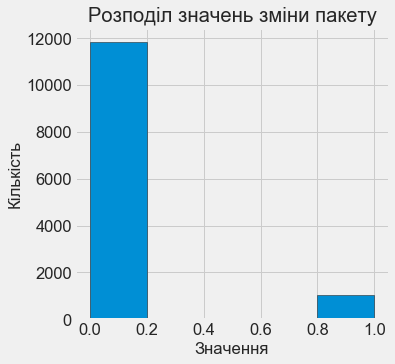

In [52]:
# для наочності відобразимо графік
from IPython.core.pylabtools import figsize

figsize(5, 5)

# Histogram 
#plt.style.use('fivethirtyeight')
plt.hist(train_set['TARGET'].dropna(), bins = 5, edgecolor = 'k');
plt.xlabel('Значення'); plt.ylabel('Кількість'); 
plt.title('Розподіл значень зміни пакету');

### Експеремент 1. Швидка реалізація 

#### У цьому експеременті виконаємо мінімально необхідну частину підготовки данних - замінемо пропущені данні. І реалізуємо прогноз лише на данних останнього місяця.

In [11]:
# Замінемо пропущені данні (NaN) на 0.
features = features.fillna(0)

In [12]:
features.describe()
# рядок count показує що пропущених данних вже нема.

,MONTH_NUM_FROM_EVENT,F1,F2,F3,F4,F5,F6,F7,F8,F9,...,F38,F39,F40,F41,F42,F43,F44,F45,F46,F47
count,103170.000000,103170.000000,103170.000000,103170.000000,103170.000000,103170.000000,103170.000000,103170.000000,103170.000000,103170.000000,...,103170.000000,103170.000000,103170.000000,103170.000000,103170.000000,103170.000000,103170.000000,103170.000000,103170.000000,103170.000000
mean,3.500000,11.620374,69.352147,20.105447,6.700136,0.035679,394.331293,378.973511,9.944030,377.047762,...,39.394465,84.281380,0.724920,1.356887,1.967597,0.555220,0.499690,0.052893,1.017050,1369.113667
std,1.707833,6.833251,50.716454,11.738800,10.825147,0.185489,564.201983,556.039192,31.129413,475.270755,...,63.151005,54.434321,1.195224,1.711068,2.107674,0.801753,0.665223,0.223822,1.052292,3645.703092
min,1.000000,-1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,2.000000,6.000000,26.000000,9.000000,0.000000,0.000000,12.370000,8.385000,0.000000,48.550000,...,6.000000,35.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,57.000000
50%,3.500000,10.000000,50.000000,26.000000,0.000000,0.000000,191.930000,174.275000,0.530000,239.030000,...,32.000000,101.000000,0.000000,1.000000,2.000000,0.000000,0.000000,0.000000,1.000000,386.000000
75%,5.000000,17.000000,119.000000,30.000000,10.000000,0.000000,555.177500,530.310000,6.820000,524.880000,...,59.000000,126.000000,1.000000,2.000000,3.000000,1.000000,1.000000,0.000000,1.000000,1032.000000
max,6.000000,25.000000,203.000000,31.000000,31.000000,1.000000,10402.770000,10384.370000,1941.920000,10516.170000,...,12038.000000,216.000000,10.000000,11.000000,13.000000,5.000000,2.000000,1.000000,106.000000,203006.000000


In [13]:
#Залишаємо лише останній місяць в данних
features_last_months = features[features.MONTH_NUM_FROM_EVENT == 1]
features_last_months.head()

,MONTH_NUM_FROM_EVENT,F1,F2,F3,F4,F5,F6,F7,F8,F9,...,F38,F39,F40,F41,F42,F43,F44,F45,F46,F47
ID,,,,,,,,,,,,,,,,,,,,,
2,1,4.0,133.0,28.0,0.0,0.0,0.00,518.98,2.60,151.33,...,89.0,137.0,0.0,2.0,2.0,1.0,0.0,0.0,2.0,958.0
4,1,5.0,139.0,29.0,7.0,0.0,682.90,676.53,3.53,591.27,...,0.0,130.0,2.0,2.0,4.0,0.0,2.0,0.0,1.0,866.0
5,1,20.0,19.0,22.0,0.0,1.0,137.98,55.78,36.03,115.33,...,44.0,12.0,0.0,0.0,0.0,2.0,0.0,0.0,1.0,146.0
8,1,21.0,134.0,29.0,21.0,1.0,459.90,408.58,11.92,485.28,...,59.0,137.0,2.0,2.0,2.0,0.0,0.0,0.0,1.0,1201.0
9,1,20.0,9.0,28.0,28.0,0.0,813.60,628.88,181.68,391.65,...,182.0,142.0,0.0,1.0,4.0,0.0,1.0,1.0,2.0,34688.0


In [14]:
# перевіримо розмірність:
print('features:', features_last_months.shape, 'train_set:', train_set.shape) 

features: (17195, 47) train_set: (12890, 1)


Схоже не по всім клієнтам є інформація щодо зміни / не зміни пакету послуг. Об'єднаємо данні в один масив на основі ID клієнта: 

In [15]:
X = features_last_months.merge(train_set, on=['ID'])

In [16]:
X.head()

,MONTH_NUM_FROM_EVENT,F1,F2,F3,F4,F5,F6,F7,F8,F9,...,F39,F40,F41,F42,F43,F44,F45,F46,F47,TARGET
ID,,,,,,,,,,,,,,,,,,,,,
2,1,4.0,133.0,28.0,0.0,0.0,0.00,518.98,2.60,151.33,...,137.0,0.0,2.0,2.0,1.0,0.0,0.0,2.0,958.0,0.0
4,1,5.0,139.0,29.0,7.0,0.0,682.90,676.53,3.53,591.27,...,130.0,2.0,2.0,4.0,0.0,2.0,0.0,1.0,866.0,0.0
5,1,20.0,19.0,22.0,0.0,1.0,137.98,55.78,36.03,115.33,...,12.0,0.0,0.0,0.0,2.0,0.0,0.0,1.0,146.0,0.0
8,1,21.0,134.0,29.0,21.0,1.0,459.90,408.58,11.92,485.28,...,137.0,2.0,2.0,2.0,0.0,0.0,0.0,1.0,1201.0,0.0
9,1,20.0,9.0,28.0,28.0,0.0,813.60,628.88,181.68,391.65,...,142.0,0.0,1.0,4.0,0.0,1.0,1.0,2.0,34688.0,0.0


До данних по клієнтам додано інформацію про зміну пакету послуг. Добре. І ще раз перевіримо розмірність:

In [17]:
X.shape

(12890, 48)

12 890 рядків - все вірно.

Розглянемо залежність ознаки зміни пакету обслуговуванн клієнта від інших ознак (кореляцію між ознаками)

In [53]:
# знайдемо всі значення кореляції та відсортуємо їх
correlations_data = X.corr()['TARGET'].sort_values()

# відобразимо данні по негативній кореляції
print(correlations_data.head(15), '\n')

# відобразимо данні по позитивній кореляції
print(correlations_data.tail(15))

F2    -0.155089
F37   -0.089351
F18   -0.079391
F44   -0.075801
F20   -0.068189
F3    -0.055866
F39   -0.053585
F4    -0.051164
F30   -0.039127
F7    -0.038814
F6    -0.034191
F47   -0.032457
F45   -0.028712
F9    -0.027586
F10   -0.026393
Name: TARGET, dtype: float64 

F33                     0.042124
F36                     0.057022
F43                     0.061364
F46                     0.064018
F34                     0.071054
F42                     0.089157
F40                     0.091805
F29                     0.101337
F41                     0.102262
F26                     0.121653
F28                     0.126064
F27                     0.130663
TARGET                  1.000000
MONTH_NUM_FROM_EVENT         NaN
F23                          NaN
Name: TARGET, dtype: float64


Що ж, сильної прямої залежності не спостерігається ні по одному з показників.

Розділимо вибірку на тренувальніта тестові набори:

In [18]:
inputs_train, inputs_test, expected_output_train, expected_output_test = train_test_split(X, train_set, test_size = 0.33, random_state = 42)
print(inputs_train.shape,inputs_test.shape, expected_output_train.shape, expected_output_test.shape)

(8636, 48) (4254, 48) (8636, 1) (4254, 1)


Застосуємо декілька алгоритмів навчання (для порівняння результатів) та визначемо їх точність прогнозування:

In [19]:
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
from sklearn.ensemble import RandomForestClassifier

In [20]:
# модель №1 LinearRegression
# ініціалізуємо модель
model = LinearRegression()
# тренуємо модель
model.fit(inputs_train, expected_output_train)

# імпортуємо метрику для оцінки
from sklearn.metrics import mean_squared_error

# розраховуємо передбачення для тестової вибірки
predictions = model.predict(inputs_test)

# розраховуємо помилку  - різницю між визначеним передбаченням та фактичними данними по зміні пакету послуг клієнтом:
mean_squared_error(predictions, expected_output_test)

4.5442551848409884e-30

Помилка склала 4,5%, тобто у 95,5% випадків передбачення буде вірним.

In [21]:
# модель №2 LogisticRegression
logit = LogisticRegression(n_jobs=-1, random_state=7)
logit.fit(inputs_train, expected_output_train)
print(round(logit.score(inputs_train, expected_output_train), 3), round(logit.score(inputs_test, expected_output_test), 3))

0.918 0.921


Тут розглянули загалом і точність на тренувальній вибірці (91,8%) та точність на тестовій вибірці (92,1%). Трохи нижчий показник в порівнянні з моделлю №1.

In [22]:
# модель №3 RandomForestClassifier
rf = RandomForestClassifier (n_estimators=100)
rf.fit(inputs_train, expected_output_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

In [23]:
accuracy = rf.score(inputs_test, expected_output_test)
print("Accuracy = {}%".format(accuracy* 100))

Accuracy = 100.0%


Точність моделі 100%. Хм.., наче не погано... або це перенавчання. Звісно необхідне подальше тестування, хоча можливо "Ліс" справляється навіть з цими мінімально обробленими данними. 

In [54]:
# збережемо модель для подальшого використання
from sklearn.externals import joblib

joblib.dump(rf, "mobile_RandFor.Cl_model1", compress=9)

['mobile_RandFor.Cl_model1']

### Побудуємо криву оцінки AUC ROC для моделі №2 LogisticRegression

In [25]:
#import pandas as pd
#import matplotlib.pyplot as plt
from matplotlib.pylab import rc, plot
import seaborn as sns
from sklearn import metrics
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.model_selection import cross_val_score
#from sklearn.linear_model import LogisticRegression
#from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.metrics import precision_recall_curve, classification_report
#from sklearn.model_selection import train_test_split

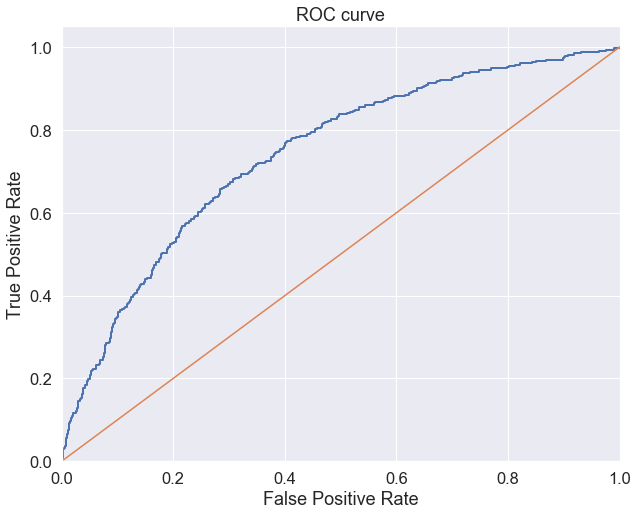

In [26]:
sns.set(font_scale=1.5)
sns.set_color_codes("muted")

plt.figure(figsize=(10, 8))
fpr, tpr, thresholds = metrics.roc_curve(expected_output_test, logit.predict_proba(inputs_test)[:,1], pos_label=1)
lw = 2
plt.plot(fpr, tpr, lw=lw, label='ROC curve ')
plt.plot([0, 1], [0, 1])
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC curve')
plt.savefig("ROC.png")
plt.show()

Крива AUC ROC візуально зображає точність моделі, для її візуальної оцінки

### Використаємо отриману модель для прогнозування нових данних та запишемо результати прогнозування в окремий файл

Виділимо з наявного списку клієнтів тих, по яким відсутня інформація по зміні тарифного плану і по ним здійснимо прогнозування.

In [27]:
Y = features_last_months.merge(train_set, on=['ID'], how='left')

In [28]:
Y.shape

(17195, 48)

In [29]:
Y['TARGET'].value_counts()

0.0    11848
1.0     1042
Name: TARGET, dtype: int64

Помітно, що даних нема по 17195 - 11848 - 1042 = 4305 рядкам. Виділимо цих клієнтів в окремий список:

In [30]:
YY = Y[(Y['TARGET'] != 0) & (Y['TARGET'] != 1)]

In [31]:
# заповнемо відсутні данні
YY = YY.fillna(-1)

In [32]:
YY.describe()

,MONTH_NUM_FROM_EVENT,F1,F2,F3,F4,F5,F6,F7,F8,F9,...,F39,F40,F41,F42,F43,F44,F45,F46,F47,TARGET
count,4305.0,4305.000000,4305.000000,4305.000000,4305.000000,4305.000000,4305.000000,4305.000000,4305.000000,4305.000000,...,4305.000000,4305.000000,4305.000000,4305.000000,4305.000000,4305.000000,4305.000000,4305.000000,4305.000000,4305.0
mean,1.0,11.992799,72.745877,20.133798,6.874564,0.034379,411.555984,387.167254,10.796065,384.869726,...,90.591405,0.773287,1.423461,2.035540,0.591638,0.537979,0.056678,1.126132,1481.225784,-1.0
std,0.0,6.533848,50.684249,11.732982,10.876827,0.182221,582.811433,560.388362,32.266924,472.291539,...,52.715874,1.223105,1.712967,2.053963,0.816036,0.686778,0.231254,1.933761,3363.232269,0.0
min,1.0,-1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-1.0
25%,1.0,6.000000,30.000000,9.000000,0.000000,0.000000,13.200000,7.570000,0.000000,55.030000,...,51.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,123.000000,-1.0
50%,1.0,10.000000,54.000000,26.000000,0.000000,0.000000,198.630000,176.780000,0.730000,243.570000,...,106.000000,0.000000,1.000000,2.000000,0.000000,0.000000,0.000000,1.000000,437.000000,-1.0
75%,1.0,17.000000,123.000000,30.000000,11.000000,0.000000,589.370000,554.380000,7.550000,539.670000,...,130.000000,1.000000,2.000000,3.000000,1.000000,1.000000,0.000000,1.000000,1153.000000,-1.0
max,1.0,25.000000,199.000000,31.000000,31.000000,1.000000,7350.530000,7345.980000,662.770000,5640.130000,...,194.000000,8.000000,9.000000,10.000000,5.000000,2.000000,1.000000,106.000000,53912.000000,-1.0


In [33]:
# здійснемо прогнозування:
y_pred = logit.predict(YY)

In [34]:
print(y_pred)

[0. 0. 0. ... 0. 0. 0.]


In [35]:
YY.index

Int64Index([    1,     3,     6,     7,    12,    18,    37,    45,    48,
               50,
            ...
            19650, 19653, 19655, 19657, 19660, 19663, 19665, 19671, 19673,
            19680],
           dtype='int64', name='ID', length=4305)

In [36]:
# та зафіксуємо результати прогнозування в окремий файл
YY_result = pd.DataFrame({
    "ID": YY.index,
    "TARGET": y_pred.clip(0. ,20.)
})
YY_result.to_csv("D:/data_sets/Kyivstar/BigDataSchool__YY_result.csv", index=False)

In [37]:
# подивимось на результат
print(YY_result['TARGET'].value_counts())

0.0    4299
1.0       6
Name: TARGET, dtype: int64


##### Отже, згідно прогнозу моделі №2:   6 клієнтів також змінили свій тарифний план.

Тепер використаємо раніше збережену модель №3 RandomForestClassifier для прогнозування цих самих данних.


In [55]:
rf = joblib.load("mobile_RandFor.Cl_model1")
pred_rf = rf.predict(YY)
print(pred_rf)

[0. 0. 0. ... 0. 0. 0.]


In [56]:
# зафіксуємо результати прогнозування в окремий файл і відобразимо результат прогнозу:
YY_rf_result = pd.DataFrame({
    "ID": YY.index,
    "TARGET": y_pred.clip(0. ,20.)
})
YY_rf_result.to_csv("D:/data_sets/Kyivstar/BigDataSchool__YY_rf_result.csv", index=False)
print(YY_rf_result['TARGET'].value_counts())

0.0    4299
1.0       6
Name: TARGET, dtype: int64


##### згідно прогнозу моделі №3: 6 клієнтів змінили свій тарифний план. В даному випадку це співпадає з прогнозом моделі №2